# Analysis using raw functions (not the MNE package)


## imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functional import seq
from scipy import signal
from itertools import combinations 

%matplotlib inline

## helper functions

### computation

In [3]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.
    Source: https://raphaelvallat.com/bandpower.html

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper
    

    band = np.asarray(band)
    low, high = band
    
    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        if data.shape[0] < nperseg:
            return np.NaN
            
        
        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
        
    return bp

In [93]:
def get_bandpower_for_electrode(signal_data, electrode, config, window_size='1s'):
    """Calculates the bandpower for the given electrode
    
    Note that this will take some time... I suggest that you only use a part of the signal to try it out.
    
    Parameters
    ----------
    signal_data: 2d pandas dataframe
        raw signal data, indexed by a timedeltaindex (or any other time-based index)
    electrode: string
        name of the electrode of interest
    config: dict
        dict of config parameters
    window_size: string
        size of rolling window
        
    Returns
    -------
    a new pandas dataframe of the bandpowers, in addition all ration combinations are listed as well
    """
    bandpowers = {}

    for band_name, band_range in config['bands'].items():
        bandpowers[band_name] = signal_data.loc[:, electrode]\
            .rolling(window_size)\
            .apply(lambda xs: bandpower(xs, config['sampling_frequency'], band_range))

    # compute all different ratios
    for bn_l, bn_r in combinations(cfg['bands'].keys(), 2):
        bandpowers[f"{bn_l} / {bn_r}"] = bandpowers[bn_l] / bandpowers[bn_r]
        
    return bandpowers 




### data loading

In [116]:
def load_signal_data(data_type, config, subject='sam', recording=0, remove_references=True):
    """loads the data and returns a pandas dataframe 
    
    Parameters
    ----------
    data_type : string
      type of the data, right now two options are valid: `baseline` or `meditation`
    subject: string
      name of the subject
    recording: int
      number of recording, if you have multiple of same type and subject
      
    Returns
    -------
    a pandas dataframe, timedeltaindexed of the raw signals
    """
    subject_paths = get_config_value(config, 'paths', 'subjects', subject)
    data = pd.read_pickle(f"{config['paths']['base']}/{subject_paths['prefix']}/offline/{get_config_value(subject_paths, 'recordings', data_type)[recording]}-raw.pcl")
    
    _t = data['timestamps'].reshape(-1)
    _t -= _t[0]

    return pd.DataFrame(data=data['signals'], 
                        index=pd.TimedeltaIndex(_t, unit='s'),
                        columns=data['ch_names']).drop(columns=config['columns_to_remove'])

### plots

In [ ]:
def plot_bandpowers(bandpowers, electrode):
    fig, axs = plt.subplots(nrows=len(bandpowers), sharex=True, figsize=(25, 15))
    time_index = list(bandpowers.values())[0].index
    time_index_as_seconds = [t.total_seconds() for t in time_index]

    for i, (bn, bp) in enumerate(bandpowers.items()):
        axs[i].plot(bp.reset_index(drop=True))
        axs[i].set_ylabel(bn)

    axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: index_to_time(x, time_index)))
    fig.suptitle(f"Bandpower of {electrode}")
    
    return fig


def plot_raw_signal(signal_pd, sampling=10):
    """
    Parameters
    ----------
    signal_pd: 2d pandas dataframe
        long-format (a column for each electrode)
    sampling: int
        step size of data points used for plotting
    
    Returns
    -------
    a figure of the plot
    
    """
    
    fig, axs = plt.subplots(nrows=signal_pd.shape[1], figsize=(40, 1.4 * signal_pd.shape[1]), sharex=True)
    for channel_id, channel in enumerate(signal_pd.columns):
        d = signal_pd.loc[::sampling, channel]
        sns.lineplot(data=d.reset_index(drop=True), ax=axs[channel_id])
        axs[channel_id].set_ylabel(channel)

    axs[-1].set_xlabel('time [ms]')
    axs[-1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: index_to_time(x, d.index)))
    
    return fig

In [87]:
def index_to_time(x, time_index, step_size=1):
    """Helper function to add the axis labels"""
    if (x < 0 or x * step_size >= len(time_index)):
        return ''
    
    seconds = time_index[int(x*step_size)].total_seconds()
    return f"{int(seconds/60)}\' {seconds/60:.2f}\""

In [88]:
def get_config_value(config, *args):
    """Helper to get read the config"""
    return reduce(lambda cfg, val: cfg[val], args, config)

# main stuff

In [115]:
# This is the config. Add any value that you deem necessary. This should contain everything that belongs to the setup, the filtering pipeline, etc.

cfg = {
    'paths': {
        'base': '../../data/AlphaTheta',
        'subjects': {
            'sam': {
                'prefix': '/sam-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-144100',
                        '20200304-144601'
                    ],
                    'meditation': [
                         '20200304-144933'   
                    ]
                }
            }
        }
    },
    'columns_to_remove': [
        'TRIGGER', 'X1', 'X2', 'X3',
    ],
    'sampling_frequency': 300,
    'bands': {
        'gamma': [40, 100],
        'beta':  [12, 40],
        'alpha': [8, 12],
        'theta': [4, 8],
        'delta': [0.5, 4]
    }
}

In [117]:
meditation_pd = load_signal_data('meditation', config=cfg)

In [118]:
electrode_of_interest = 'O2'

In [ ]:
meditation_bandpower  = get_bandpower_for_electrode(meditation_pd, electrode=electrode_of_interest, config=cfg)

In [ ]:
plot_raw_signal(meditation_pd);

In [ ]:
plot_bandpowers(meditation_bandpower, electrode=electrode_of_interest);

# Graveyard, not interesting below here

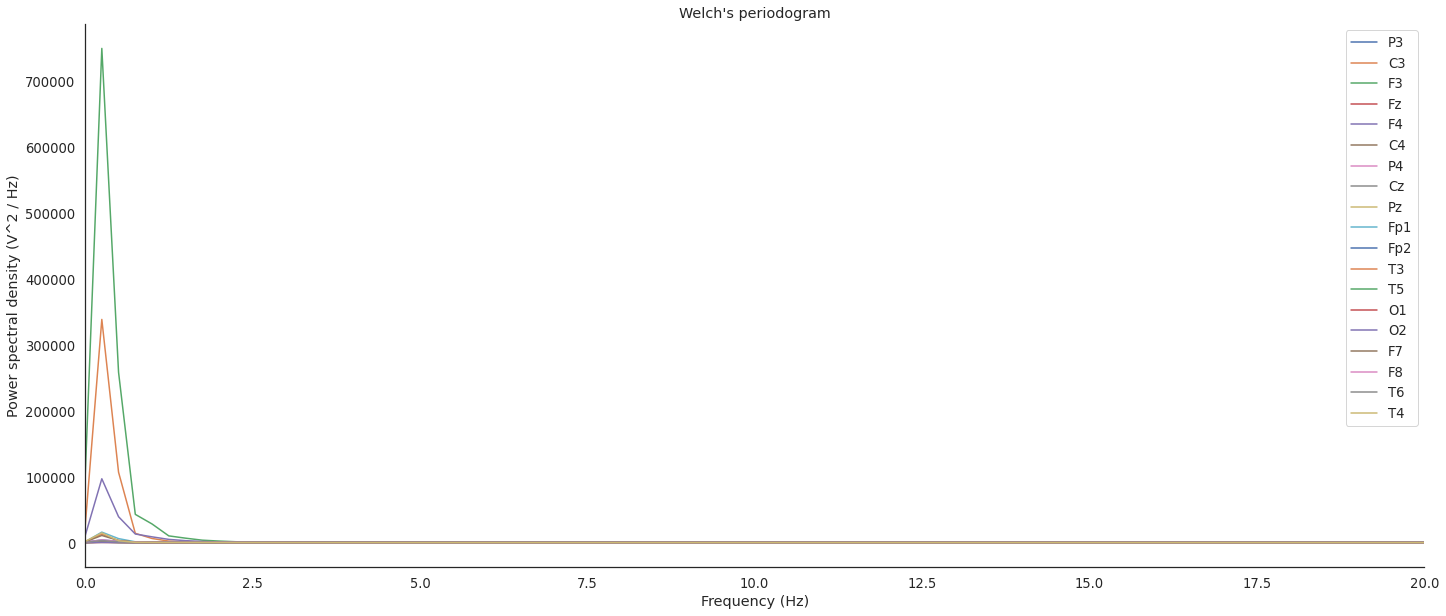

In [208]:
sampling_rate = 300
window_size = 4 * sampling_rate # in seconds

plt.figure(figsize=(24, 10))
for c in [c for c in signals_pd.columns if c not in ['TRIGGER', 'X1', 'X2', 'X3', 'A2']]:
    freqs, psd = signal.welch(signals_pd.loc[:, c], sampling_rate, nperseg=window_size)

    plt.plot(freqs, psd, label=c)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    #plt.ylim([0, psd.max() * 1.1])
    plt.title("Welch's periodogram")
    #plt.xlim([0, freqs.max()])
    plt.xlim([0, 20])
    sns.despine()
    
plt.legend();

In [213]:
# for a window size of... compute the power and compare it over time



bandpower(signals_pd.loc[:, 'T5'], 300., cfg['bands']['theta'])

7.676781094175913

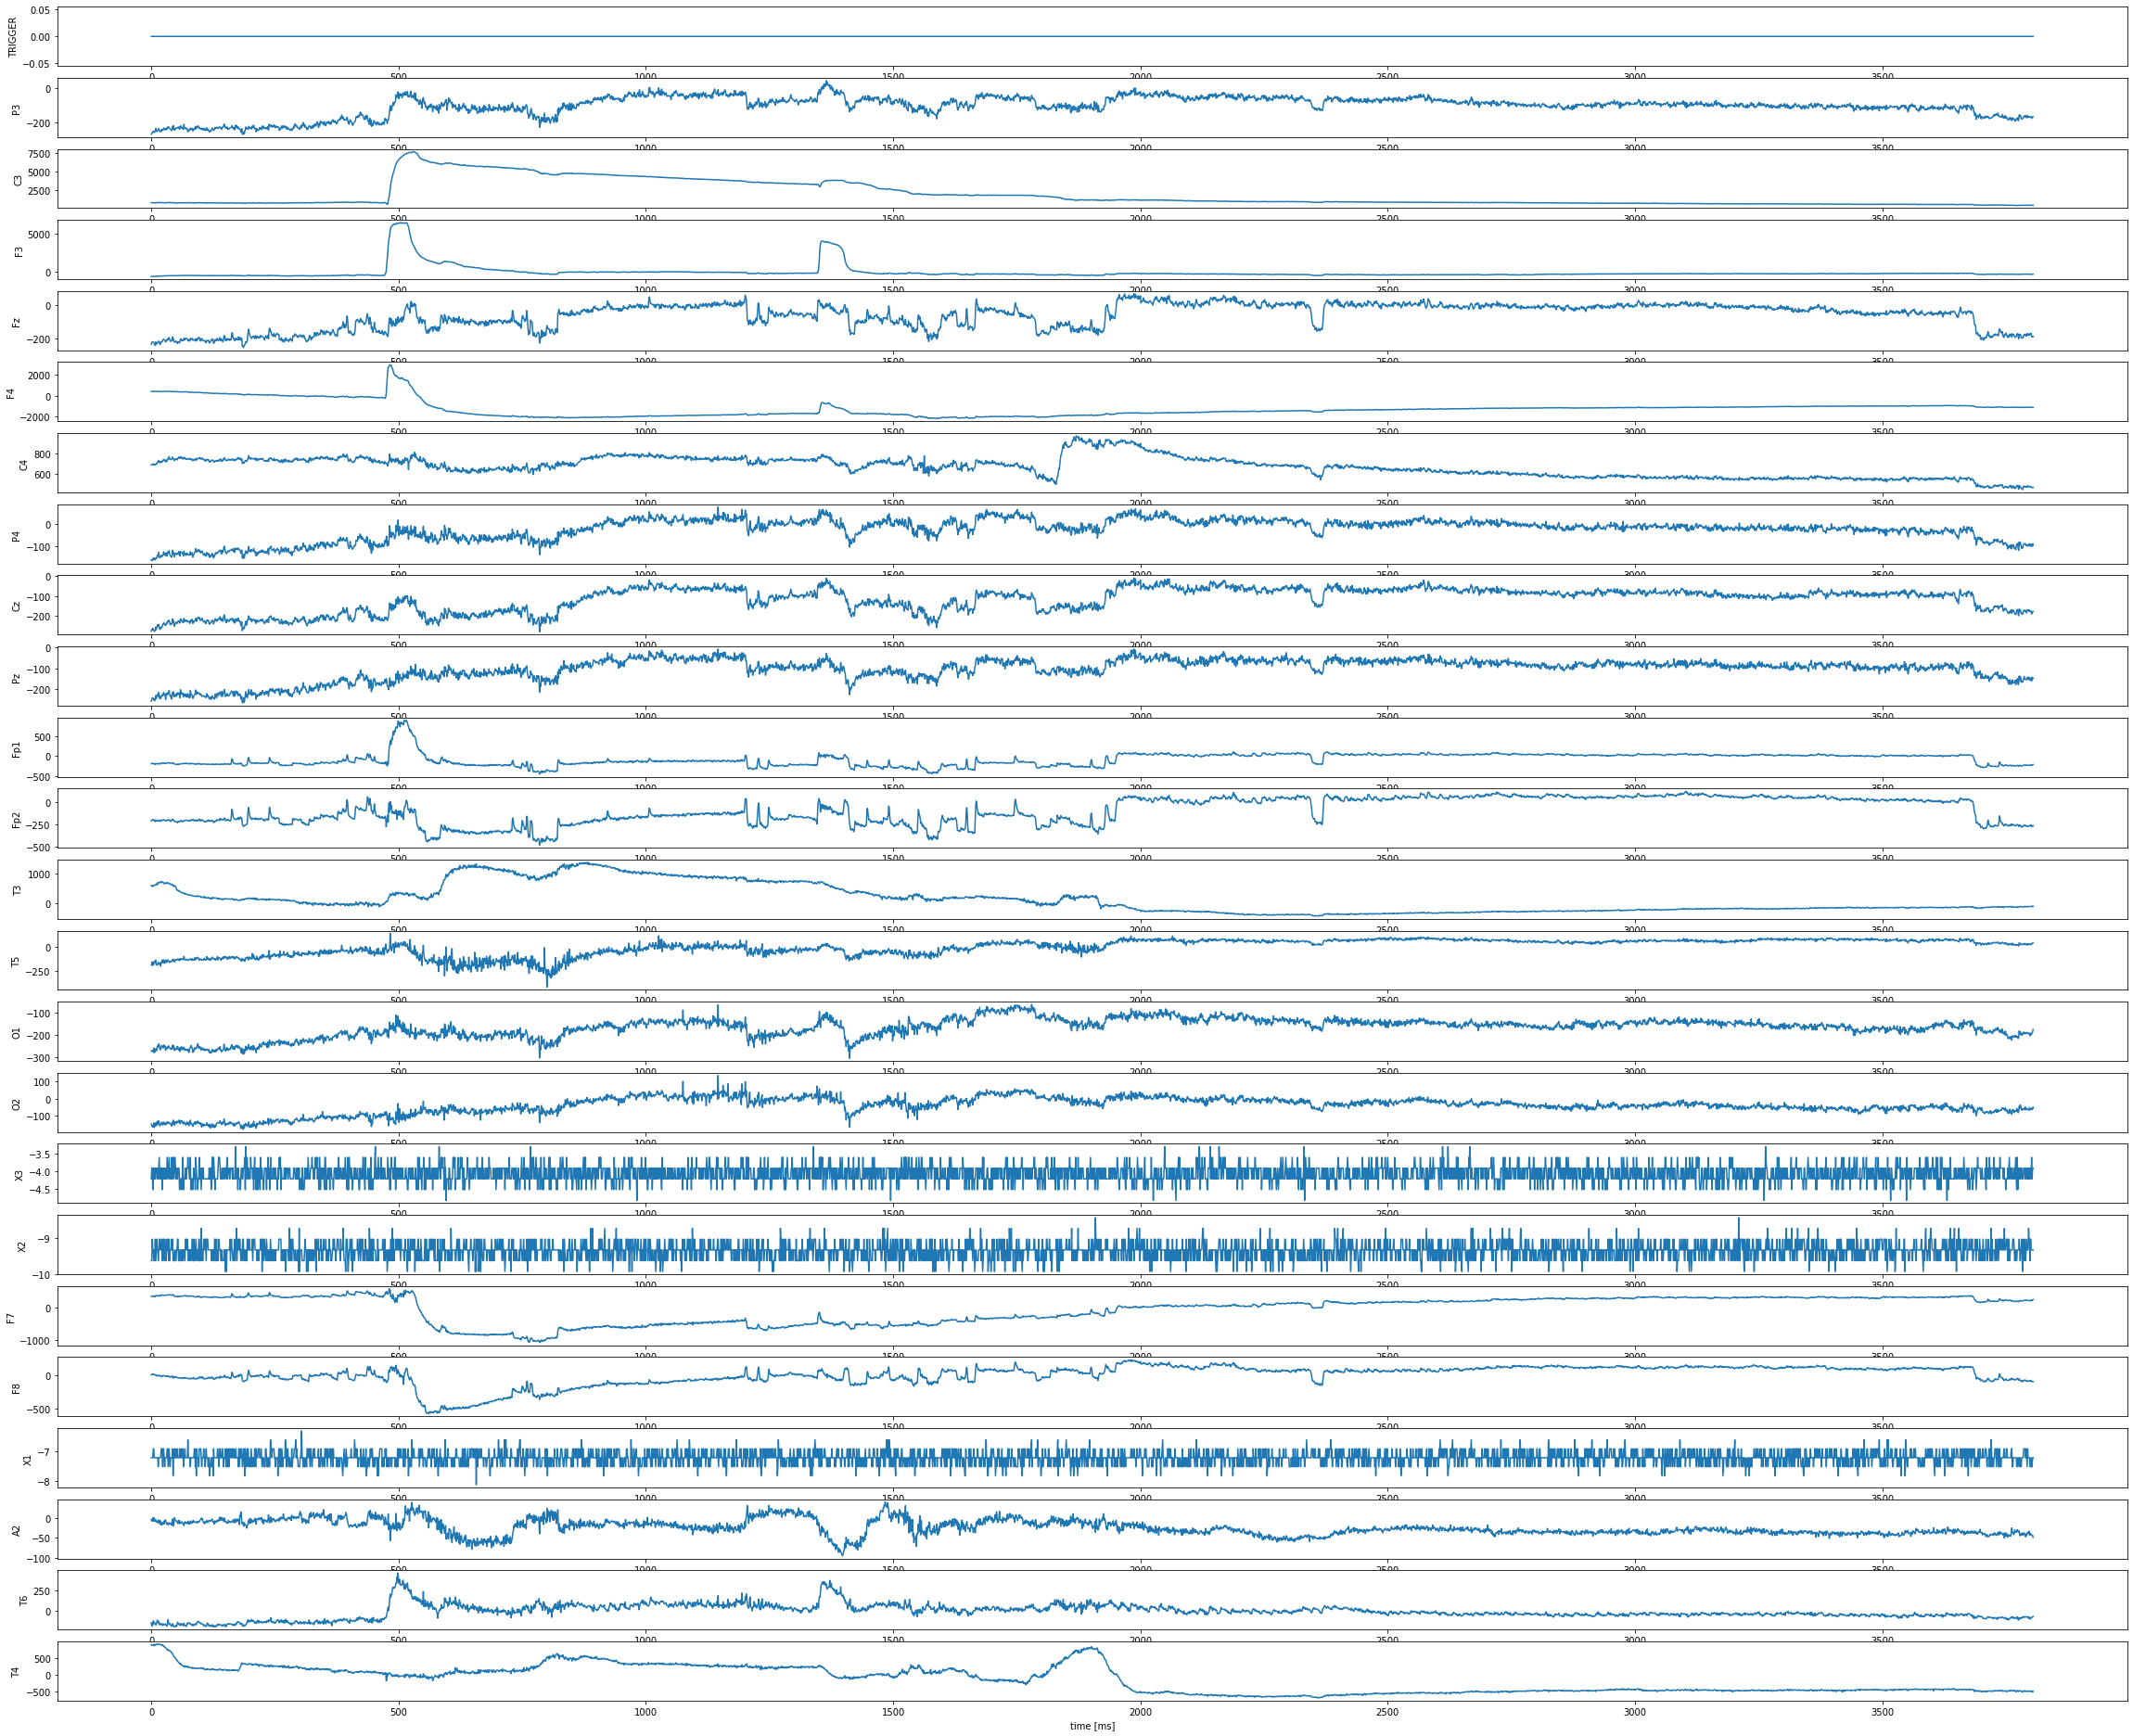

In [36]:
signals = baseline['signals']
fig, axs = plt.subplots(nrows=signals.shape[1], figsize=(40, 1.4 * signals.shape[1]))
for channel in range(signals.shape[1]):
    sns.lineplot(data=signals[::10, channel], ax=axs[channel], )
    axs[channel].set_ylabel(baseline['ch_names'][channel])
    
axs[-1].set_xlabel('time [ms]');

In [31]:
38052/60

634.2